https://github.com/keeganhines/gp/blob/master/gp.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GaussianProcess(object):
    def __init__(self):
        self.X_train = None
        self.Y_train = None
        
        self.ls = None
        self.var_s = None
        self.var_k = None
        
        self.K = None
        
    def rbf_kernel(self, a, b):
        param = self.ls**2
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2 * np.dot(a, b.T)
        return self.var_k * np.exp(-.5 * (1/param) * sqdist)
    
    def fit(self, X_train, Y_train, length_scale, kernel_variance, likelihood_variance):
        self.X_train = X_train
        self.Y_train = Y_train
        
        self.ls = length_scale
        self.var_k = kernel_variance
        self.var_s = likelihood_variance
                
        K = self.rbf_kernel(self.X_train, self.X_train) + (self.var_s)*np.eye(self.X_train.shape[0])
        self.K = np.linalg.inv(K)
        
    def predict_mean(self, X_test):
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        mu = np.dot( np.dot(K_s,K), self.Y_train ) 
        return mu[:,0]
    
    def predict_variance(self, X_test):
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        K_ss = self.rbf_kernel(X_test, X_test)
        covariance = K_ss - np.dot( np.dot(K_s,K), K_s.T )
        var = np.diag(covariance)
        return var
    
    def params(self):
        return self.ls, self.var_k, self.var_s
    
    def sample_posterior(self, X_test):
        mu = self.predict_mean(X_test)
        
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        K_ss = self.rbf_kernel(X_test, X_test)
        covariance = K_ss - np.dot( np.dot(K_s,K), K_s.T )
        
        f_post =  np.random.multivariate_normal(mu, covariance)
        
        return f_post
        

In [48]:
class GaussianProcess2(object):
    def __init__(self):
        self.X_train = None
        self.Y_train = None
        
        self.ls = None
        self.var_s = None
        self.var_k = None
        
        self.K = None
        
    def rbf_kernel(self, a, b):
        param = self.ls**2
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2 * np.dot(a, b.T)
        return self.var_k * np.exp(-.5 * (1/param) * sqdist)
    
    def fit(self, X_train, Y_train, length_scale, kernel_variance, likelihood_variance):
        self.X_train = X_train
        self.Y_train = Y_train
        
        self.ls = length_scale
        self.var_k = kernel_variance
        self.var_s = likelihood_variance
            
        self.K = self.rbf_kernel(self.X_train, self.X_train) + (self.var_s)*np.eye(self.X_train.shape[0])
        
    def predict_mean(self, X_test):
        K = self.K
        K = np.linalg.cholesky(K)
        alpha = np.linalg.solve(K.T, np.linalg.solve(K,Y_train))
        K_s = self.rbf_kernel(X_test, self.X_train)
        mu = np.dot(K_s , alpha) 
        return mu[:,0]
    
    def predict_variance(self, X_test):
        K = self.K
        K = np.linalg.cholesky(K)
        K_s = self.rbf_kernel(self.X_train, X_test)
        alpha = np.linalg.solve(K, K_s)
        K_ss = self.rbf_kernel(X_test, X_test)
        covariance = K_ss - np.dot(alpha.T, alpha)
        var = np.diag(covariance)
        return var
    
    def params(self):
        return self.ls, self.var_k, self.var_s

In [58]:
N = 10
sigma = .2
X_train = np.linspace(1,5,N).reshape(-1,1)
X_train = np.concatenate(5*[X_train])
Y_train = np.sin(5*X_train) + np.cos(.7*X_train) + np.random.normal(0,sigma,X_train.shape[0]).reshape(-1,1)
n = 500
X_test = np.linspace(0,6,n).reshape(-1,1)

In [59]:
gp = GaussianProcess()
gp.fit(X_train, Y_train, np.sqrt(0.2), 1.0, sigma**2)
mu = gp.predict_mean(X_test)
var = gp.predict_variance(X_test)

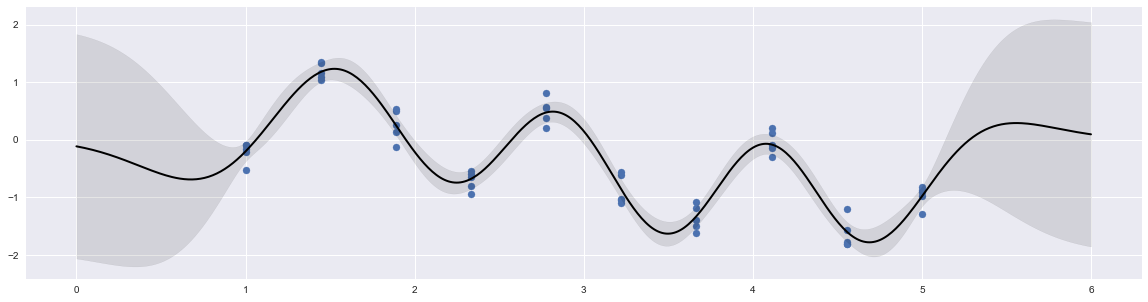

In [60]:
plt.figure(figsize=(20,5))
plt.plot(X_test, mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

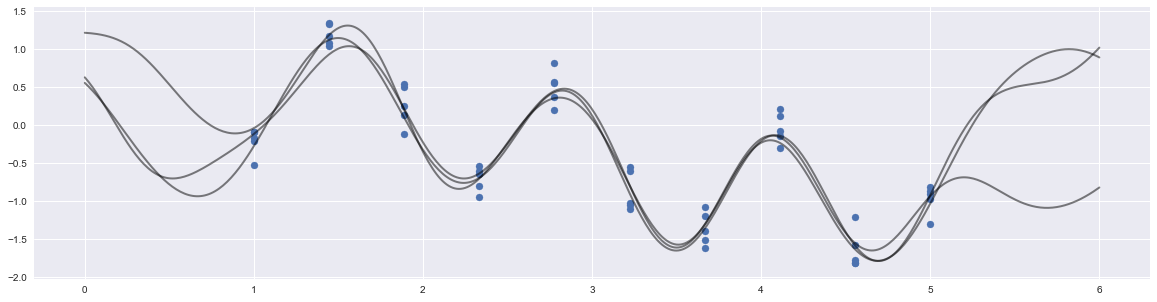

In [64]:
plt.figure(figsize=(20,5))
for i in range(3):
    sample_f = gp.sample_posterior(X_test)
    plt.plot(X_test, sample_f, 'k', mew=1, lw=2, label='sample from posterior', alpha=.5)
plt.scatter(X_train, Y_train)
plt.show()

In [55]:
gp = GaussianProcess2()
gp.fit(X_train, Y_train, np.sqrt(0.2), 1.0, sigma**2)
mu = gp.predict_mean(X_test)
var = gp.predict_variance(X_test)

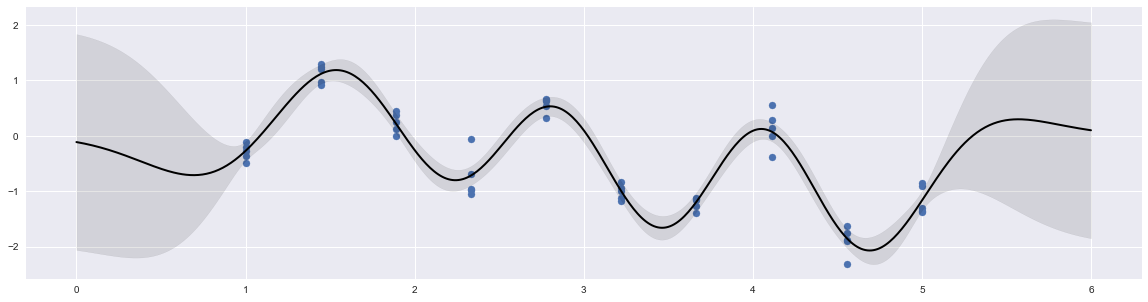

In [56]:
plt.figure(figsize=(20,5))
plt.plot(X_test, mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

### Sampling

In [12]:
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
N = 10
sigma = .2
X_train = np.linspace(1,5,N).reshape(-1,1)
X_train = np.concatenate(5*[X_train])
Y_train = np.sin(5*X_train) + np.cos(.7*X_train) + np.random.normal(0,sigma,X_train.shape[0]).reshape(-1,1)
n = 500
X_test = np.linspace(0,6,n).reshape(-1,1)

In [14]:
samples = 5000

var_s_current = stats.halfnorm(0.0, 0.5).rvs()
posterior_var_s = [var_s_current]

ls = 0.2
var_k = 1.0

for i in range(samples):
    var_s_proposal = var_s_current + np.random.choice([-0.1,0.1]) #stats.uniform(-0.5,1.0).rvs()
    
    if i % 500 == 0:
        print i
    
    if var_s_proposal > 0:
    
        gp = GaussianProcess2()
        gp.fit(X_train, Y_train, np.sqrt(ls), var_k, var_s_proposal)
        mu = gp.predict_mean(X_train)
        var = gp.predict_variance(X_train)
    
        likelihood_proposal = []
        for i, x in enumerate(X_train[:,0]):
            likelihood_proposal.append( 
                stats.norm(mu[i], np.sqrt(var[i])).logpdf(x) 
            )
        likelihood_proposal = np.sum(likelihood_proposal)
    
        gp = GaussianProcess2()
        gp.fit(X_train, Y_train, np.sqrt(ls), var_k, var_s_current)
        mu = gp.predict_mean(X_train)
        var = gp.predict_variance(X_train)
    
        likelihood_current = []
        for i, x in enumerate(X_train[:,0]):
            likelihood_current.append( 
                stats.norm(mu[i], np.sqrt(var[i])).logpdf(x) 
            )
        likelihood_current = np.sum(likelihood_current)
        
        prior_proposal = stats.foldnorm(0.2, 0.1).logpdf(var_s_proposal)
        prior_current = stats.foldnorm(0.2, 0.1).logpdf(var_s_current)
        
        p_proposal = likelihood_proposal + prior_proposal
        p_current = likelihood_current + prior_current
    
        p_accept = p_proposal / p_current
        if p_accept is np.nan:
            p_accept = 0
        
        accept = np.random.rand() < p_accept
        
        if accept:
            var_s_current = var_s_proposal
        
        posterior_var_s.append(var_s_current)


0
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.25552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.25552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.25552150e+00 ...,   4.34850256e-06
    1.90199430e-08 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
1000
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ..., 

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.15552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.15552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.15552150e+00]]
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]
[[  1.15552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.15552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.15552150e+00 ...,   4.34850256e-06
    1.90199430e-08   

Posterior Samples: 2498


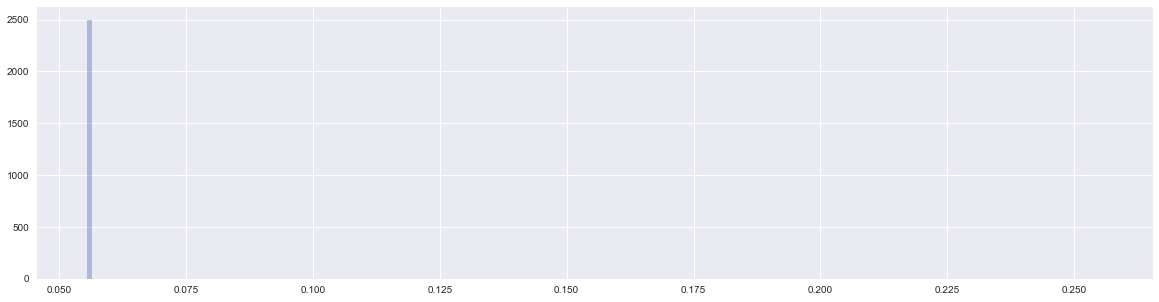

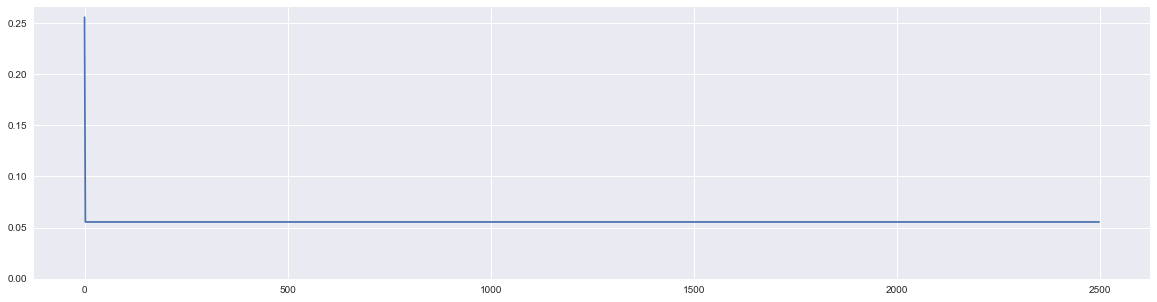

In [24]:
print "Posterior Samples: {}".format( len(posterior_var_s) )

plt.figure(figsize=(20,5))
sns.distplot(posterior_var_s,kde=False,bins=200)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(posterior_var_s)
ymin, ymax = plt.ylim()
plt.ylim(0,ymax)
plt.show()

0.0555214952422
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]


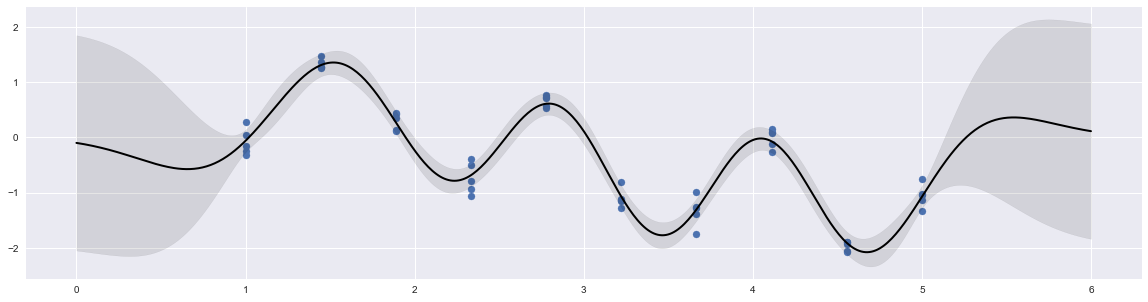

0.0555214952422
[[  1.05552150e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05552150e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05552150e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05552150e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05552150e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05552150e+00]]


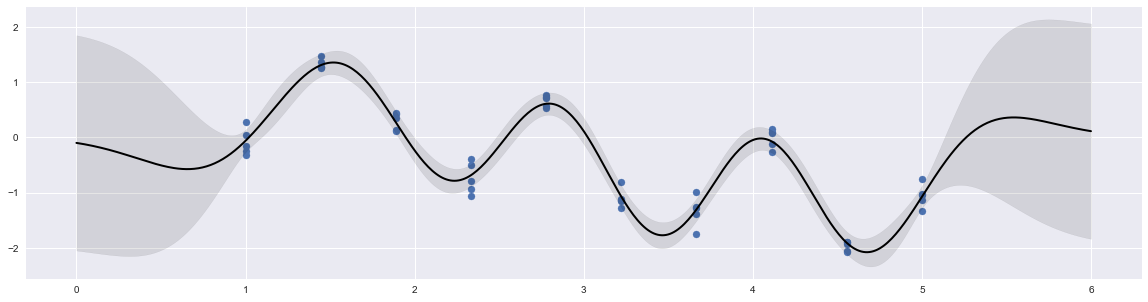

[ 0.056]
[[  1.05600000e+00   6.10286256e-01   1.38718491e-01 ...,   3.09845983e-11
    1.87996476e-14   4.24835426e-18]
 [  6.10286256e-01   1.05600000e+00   6.10286256e-01 ...,   1.90199430e-08
    3.09845983e-11   1.87996476e-14]
 [  1.38718491e-01   6.10286256e-01   1.05600000e+00 ...,   4.34850256e-06
    1.90199430e-08   3.09845983e-11]
 ..., 
 [  3.09845983e-11   1.90199430e-08   4.34850256e-06 ...,   1.05600000e+00
    6.10286256e-01   1.38718491e-01]
 [  1.87996476e-14   3.09845983e-11   1.90199430e-08 ...,   6.10286256e-01
    1.05600000e+00   6.10286256e-01]
 [  4.24835426e-18   1.87996476e-14   3.09845983e-11 ...,   1.38718491e-01
    6.10286256e-01   1.05600000e+00]]


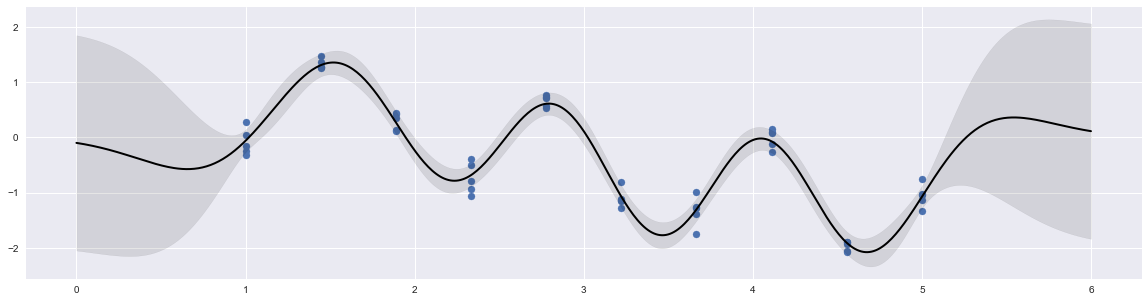

In [29]:
a = np.mean(posterior_var_s[2000:])
print(a)

gp = GaussianProcess2()
gp.fit(X_train, Y_train, np.sqrt(0.2), 1.0, a)
mu = gp.predict_mean(X_test)
var = gp.predict_variance(X_test)

plt.figure(figsize=(20,5))
plt.plot(X_test, mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

a = np.median(posterior_var_s[2000:])
print(a)

gp = GaussianProcess2()
gp.fit(X_train, Y_train, np.sqrt(0.2), 1.0, a)
mu = gp.predict_mean(X_test)
var = gp.predict_variance(X_test)

plt.figure(figsize=(20,5))
plt.plot(X_test, mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

a = stats.mode( np.round(posterior_var_s[2000:],3) )[0]
print(a)

gp = GaussianProcess2()
gp.fit(X_train, Y_train, np.sqrt(0.2), 1.0, a)
mu = gp.predict_mean(X_test)
var = gp.predict_variance(X_test)

plt.figure(figsize=(20,5))
plt.plot(X_test, mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

### Classification

In [3]:
class GaussianProcess(object):
    def __init__(self):
        self.X_train = None
        self.Y_train = None
        
        self.ls = None
        self.var_s = None
        self.var_k = None
        
        self.K = None
        
    def rbf_kernel(self, a, b):
        param = self.ls**2
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2 * np.dot(a, b.T)
        return self.var_k * np.exp(-.5 * (1/param) * sqdist)
    
    def fit(self, X_train, Y_train, length_scale, kernel_variance, likelihood_variance):
        self.X_train = X_train
        self.Y_train = Y_train
        
        self.ls = length_scale
        self.var_k = kernel_variance
        self.var_s = likelihood_variance
                
        K = self.rbf_kernel(self.X_train, self.X_train) + (self.var_s)*np.eye(self.X_train.shape[0])
        self.K = np.linalg.inv(K)
        
    def predict_mean(self, X_test):
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        mu = np.dot( np.dot(K_s,K), self.Y_train ) 
        return mu[:,0]
    
    def predict_variance(self, X_test):
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        K_ss = self.rbf_kernel(X_test, X_test)
        covariance = K_ss - np.dot( np.dot(K_s,K), K_s.T )
        var = np.diag(covariance)
        return var
    
    def params(self):
        return self.ls, self.var_k, self.var_s
    
    def sample_posterior(self, X_test):
        mu = self.predict_mean(X_test)
        
        K = self.K
        K_s = self.rbf_kernel(X_test, self.X_train)
        K_ss = self.rbf_kernel(X_test, X_test)
        covariance = K_ss - np.dot( np.dot(K_s,K), K_s.T )
        
        f_post =  np.random.multivariate_normal(mu, covariance)
        
        return f_post
        

In [4]:
from sklearn import linear_model, datasets

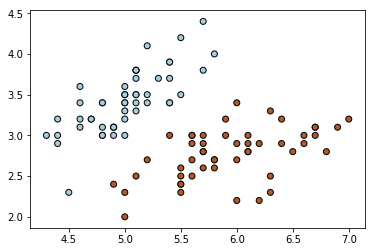

In [52]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

X = X[Y < 2]
Y = Y[Y < 2]
Y[Y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

In [55]:
gp = GaussianProcess()
gp.fit(X[:, 0].reshape(-1,1), Y.reshape(-1,1), np.sqrt(1.0), 1.0, 1.0)

test = X[:, 0]
test.sort()
mu = gp.predict_mean(test.reshape(-1,1))
var = gp.predict_variance(X[:, 0].reshape(-1,1))

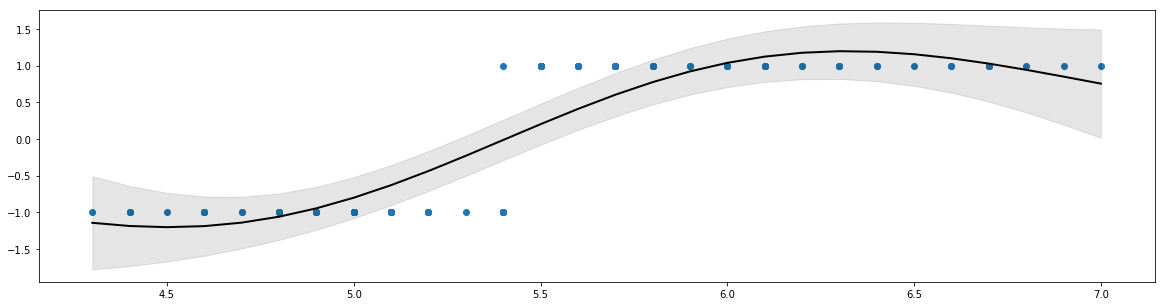

In [56]:
plt.figure(figsize=(20,5))
plt.plot(X[:, 0], mu, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X[:, 0], Y)
plt.fill_between(test, mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var), 
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

In [57]:
s = gp.sample_posterior(test.reshape(-1,1))

def logit(s):
    s = (1+np.exp(-s))**(-1)
    return s

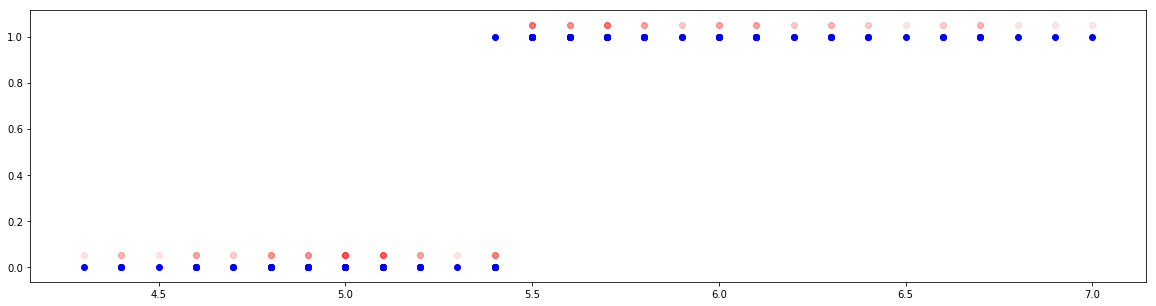

In [61]:
predictions = logit(mu).round(0)
Y[Y == -1] = 0

plt.figure(figsize=(20,5))
plt.scatter(X[:, 0], Y,alpha=1.0,c='b')
plt.scatter(test, predictions+.05,alpha=0.1,c='r')
plt.show()